In [1]:
%load_ext autoreload
%autoreload 2

import torch
import notebook_setup

device = torch.device('cpu')

/home/brendan/anaconda3/envs/impl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Define data distribution and take a sample

In [2]:
from csv import reader
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
from callbacks import UpdateProgressBarStats
from implicit.datasets import ProjectedNormal
from visualization import plot_3d_points, plot_surface


def load_csv(filename):
    file = open(filename, "r")
    lines = reader(filter(lambda row: row[0] != "#", file))
    dataset = list(lines)
    return dataset


def cartesian_from_latlon(x):
    """ Embedded 3D unit vector from spherical polar coordinates.
    Parameters
    ----------
    phi, theta : float or numpy.array
        azimuthal and polar angle in radians.
    Returns
    -------
    nhat : numpy.array
        unit vector(s) in direction (phi, theta).
    """
    assert x.shape[-1] == 2
    lat = x.select(-1, 0)
    lon = x.select(-1, 1)
    x = torch.cos(lat) * torch.cos(lon)
    y = torch.cos(lat) * torch.sin(lon)
    z = torch.sin(lat)
    return torch.cat([x.unsqueeze(-1), y.unsqueeze(-1), z.unsqueeze(-1)], dim=-1)


dataset = np.array(load_csv('./data/earth_data/flood.csv'))
dataset = torch.Tensor(dataset[1:, :].astype(float))
data = cartesian_from_latlon(dataset / 180 * math.pi)

plot_lims = {"xlims": (-1.1, 1.1), "ylims": (-1.1, 1.1), "zlims": (-1.03, 1.03)} # Set lims for each plot
lims = {"xlims": (-1.3, 1.3), "ylims": (-1.3, 1.3), "zlims": (-1.3, 1.3)} # Set lims for ebm
ebm_lims = torch.Tensor((lims["xlims"], lims["ylims"], lims["zlims"])).T

dataloader = data.split(50)
callbacks = [UpdateProgressBarStats(loader=dataloader)]

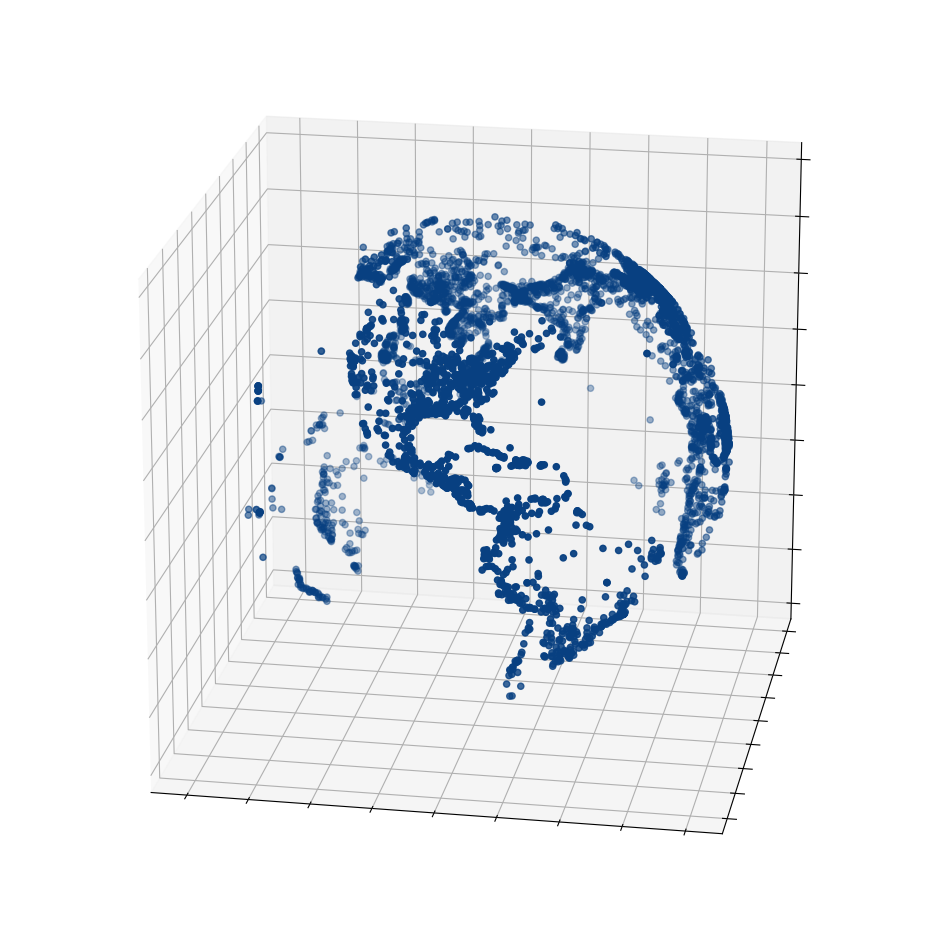

In [3]:
fig = plt.figure(figsize=(12, 12))
plot_3d_points(data, ax=fig.add_subplot(projection="3d"), **plot_lims, elev=20, azim=280, equal_aspect=True)

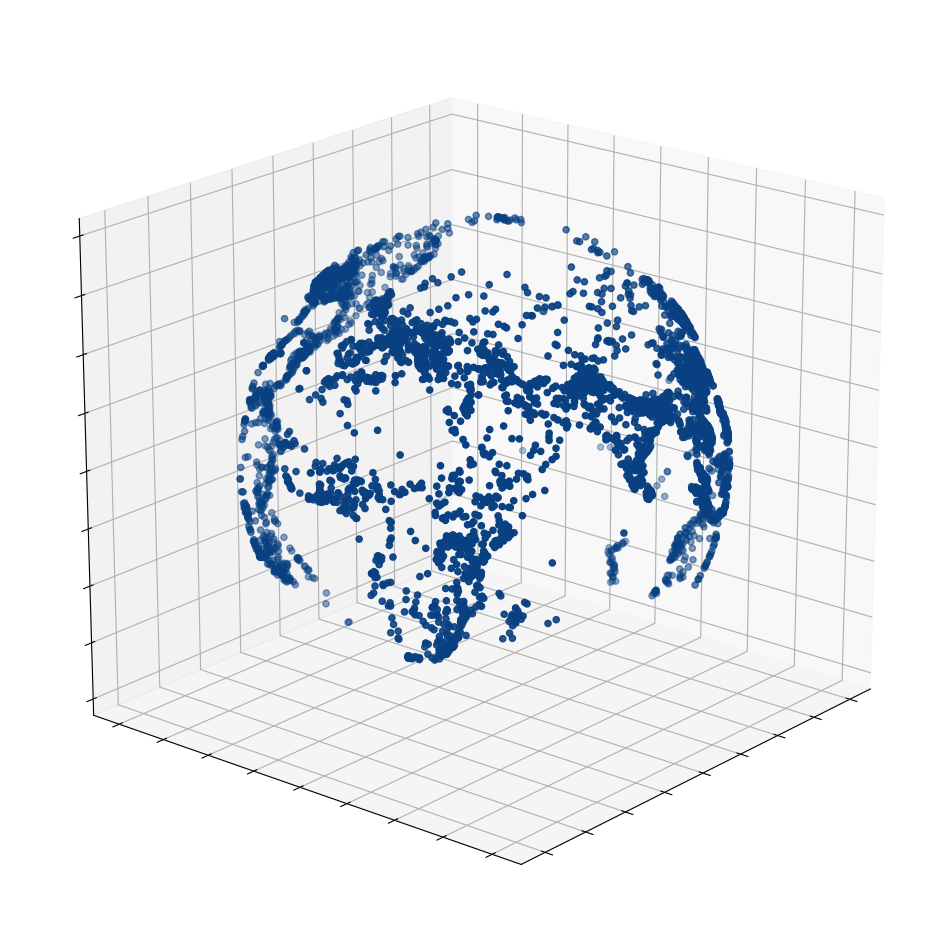

In [4]:
fig = plt.figure(figsize=(12, 12))
plot_3d_points(data, ax=fig.add_subplot(projection="3d"), **plot_lims, elev=20, azim=40, equal_aspect=True)

## EBIM

Train an MDF

In [5]:
%%time
from torch import optim
from implicit.maps import FlatSmoothMap
from implicit.models.ebm import ImplicitManifold

mdf = FlatSmoothMap(3, 1, hidden_size=8)
manifold = ImplicitManifold(mdf, ebm_lims, device)
opt = optim.Adam(mdf.parameters(), lr=0.01)

manifold.train(
    optim=opt,
    dataloader=dataloader,
    epochs=300,
    neg_weight=0.3,
    mu=10.,
    sv_min=0.1,
    buffer_frac=0.95,
    mc_kwargs={
        "eps": 0.1,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E300] loss: -0.0152 | pos: 0.0015 | neg: 0.1123 | sv_min: 0.0000 | sv_max: 0.0000 | scale: 0.0171: 100%|████████████| 300/300 [22:20<00:00,  4.47s/it]

CPU times: user 22min 22s, sys: 15.7 s, total: 22min 37s
Wall time: 22min 20s


In [6]:
from implicit.metrics import distance_to_implicit_manifold

implicit_dists = distance_to_implicit_manifold(data, manifold)
implicit_dists.min(), implicit_dists.median(), implicit_dists.mean(), implicit_dists.max()

(tensor(5.3960e-07), tensor(0.0013), tensor(0.0014), tensor(0.0181))

Train a constrained EBM

In [7]:
 %%time
from implicit.models.ebm import ConstrainedEBM

energy = FlatSmoothMap(3, 1, num_layers=4, spectral_norm=False)
cebm = ConstrainedEBM(manifold, energy, lims=ebm_lims, device=device, buffer_size=1000)
opt = optim.Adam(energy.parameters(), lr=0.01)

cebm.train(
    optim=opt,
    dataloader=dataloader, 
    epochs=100,
    beta=0.1,
    clip_norm=1.,
    buffer_frac=0.95,
    noise_kwargs={
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    mc_kwargs={
        "n_steps": 5,
        "eps": 0.1,
        "alpha": None,
        "grad_clamp": 0.03,
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe"
    },
    callbacks=callbacks,
)

[E100] loss: -3.0770 | scale_loss: 29.0407: 100%|██████████████████████████████████████████████████████████████████| 100/100 [1:07:04<00:00, 40.24s/it]

CPU times: user 1h 7min 27s, sys: 12.2 s, total: 1h 7min 39s
Wall time: 1h 7min 6s


In [8]:
import matplotlib.colors as colors
from matplotlib import cm

cmap_gnbu = cm.GnBu # default colormap
# darkened colormap
cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap_gnbu.name, a=0.2, b=1.0),
        cmap_gnbu(np.linspace(0.2, 1.0, 100)))

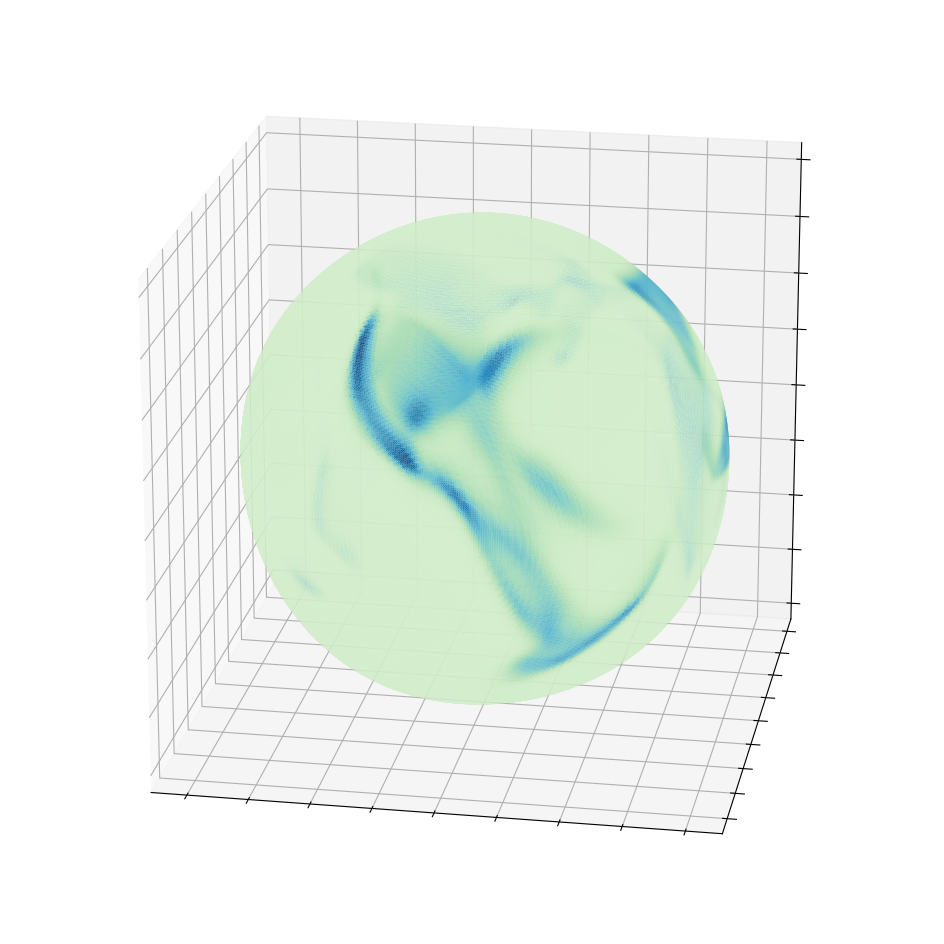

In [9]:
from visualization import plot_mdf_surface

uniform_points = ProjectedNormal(concentration=(0., 0., 0.)).sample(10000)
mc_partition = torch.exp(-energy(uniform_points)).squeeze().mean() * 4 * np.pi

density_func = lambda x: torch.exp(-energy(x) / 2).squeeze() / mc_partition


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")
plot_mdf_surface(mdf, density_func, res=250, **plot_lims, ax=ax, elev=20, azim=280, equal_aspect=True, cmap=cmap)
ax.view_init(elev=20, azim=280)

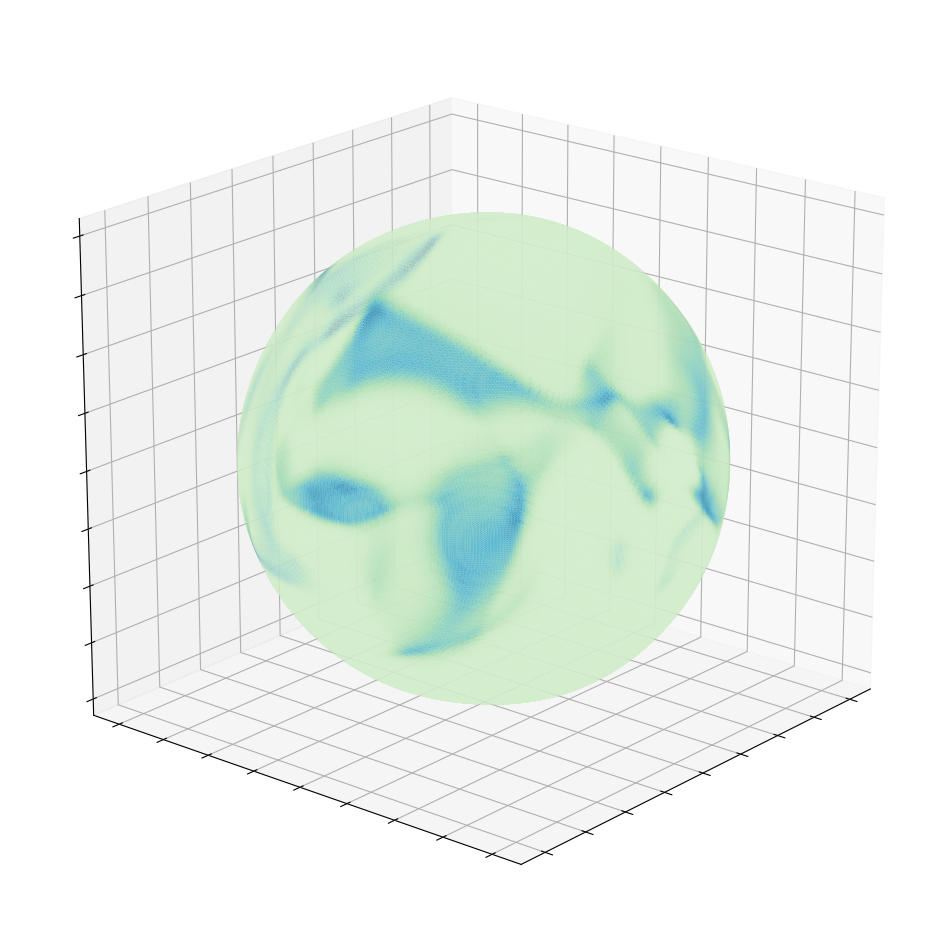

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")
plot_mdf_surface(mdf, density_func, res=250, **plot_lims, ax=ax, elev=20, azim=280, equal_aspect=True, cmap=cmap)
ax.view_init(elev=20, azim=40)

In [11]:
from implicit.metrics import wasserstein_discretized_density_to_points

gt_points = data
learned_points = cebm.sample_noise(10000, batch_size=3000, line_search_fn="strong_wolfe")
with torch.no_grad():
    learned_densities = density_func(learned_points)

wasserstein_discretized_density_to_points(
    learned_points,
    learned_densities,
    gt_points,
    ebm_lims.T.numpy(),
    granularity=30,
)

0.020029725965885193

## Pushforward EBM

In [13]:
%%time
from itertools import chain
from implicit.models.ebm import PushforwardEBM
from implicit.models.autoencoder import Autoencoder

encoder = FlatSmoothMap(3, 2, num_layers=4)
decoder = FlatSmoothMap(2, 3, num_layers=4)
latent_energy = FlatSmoothMap(2, 1, num_layers=4, spectral_norm=False)

ae = Autoencoder(encoder, decoder, device=device)
ae_ebm = PushforwardEBM(ae, latent_energy, device=device, buffer_size=1000)

ae_ebm.train_ae(
    optim=optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001),
    dataloader=data.split(100), 
    epochs=500,
    clip_norm=1.,
    callbacks=callbacks,
)

[E250] loss: 0.0000: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.24it/s]

CPU times: user 2min 36s, sys: 10.6 s, total: 2min 47s
Wall time: 2min 34s


In [14]:
from implicit.metrics import distance_to_pushforward_manifold

ae_dists = distance_to_pushforward_manifold(data, ae_ebm.autoencoder)
ae_dists.min(), ae_dists.median(), ae_dists.mean(), ae_dists.max()

(tensor(1.5757e-05), tensor(0.0016), tensor(0.0018), tensor(0.0103))

In [15]:
%%time

ae_ebm.train_ebm(
    optim=optim.Adam(latent_energy.parameters(), lr=0.01),
    dataloader=dataloader, 
    epochs=50, 
    beta=0.1,
    clip_norm=1.,
    buffer_frac=0.95,  
    mc_kwargs={
        "n_steps": 60,
        "eps": 0.5,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E 50] loss: -2.9689 | scale_loss: 27.7197: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [09:47<00:00, 11.74s/it]

CPU times: user 9min 45s, sys: 4.77 s, total: 9min 50s
Wall time: 9min 47s


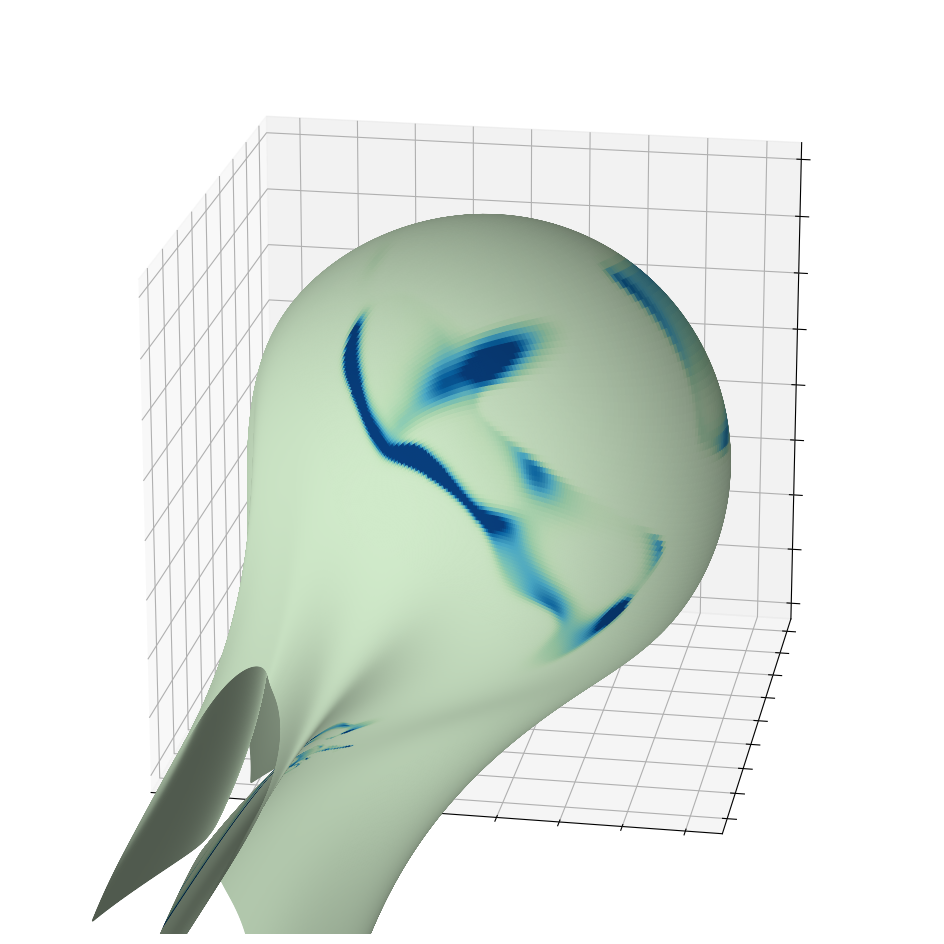

In [16]:
with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    x = torch.linspace(lower[0].tolist(), upper[0].tolist(), 500)
    y = torch.linspace(lower[1].tolist(), upper[1].tolist(), 500)

    latent_grid = torch.stack(torch.meshgrid((x, y), indexing="xy"), dim=-1)
    ambient_grid = decoder(latent_grid)
    densities = ae_ebm.prob(ambient_grid.reshape(-1, 3))
    densities = densities.reshape(*latent_grid.shape[:-1])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")
plot_surface(ambient_grid, facecolors=densities, cmap=cmap, ax=ax, equal_aspect=True,
             **plot_lims, lightsource=mcolors.LightSource(azdeg=20, altdeg=0))

ax.view_init(elev=20, azim=280)

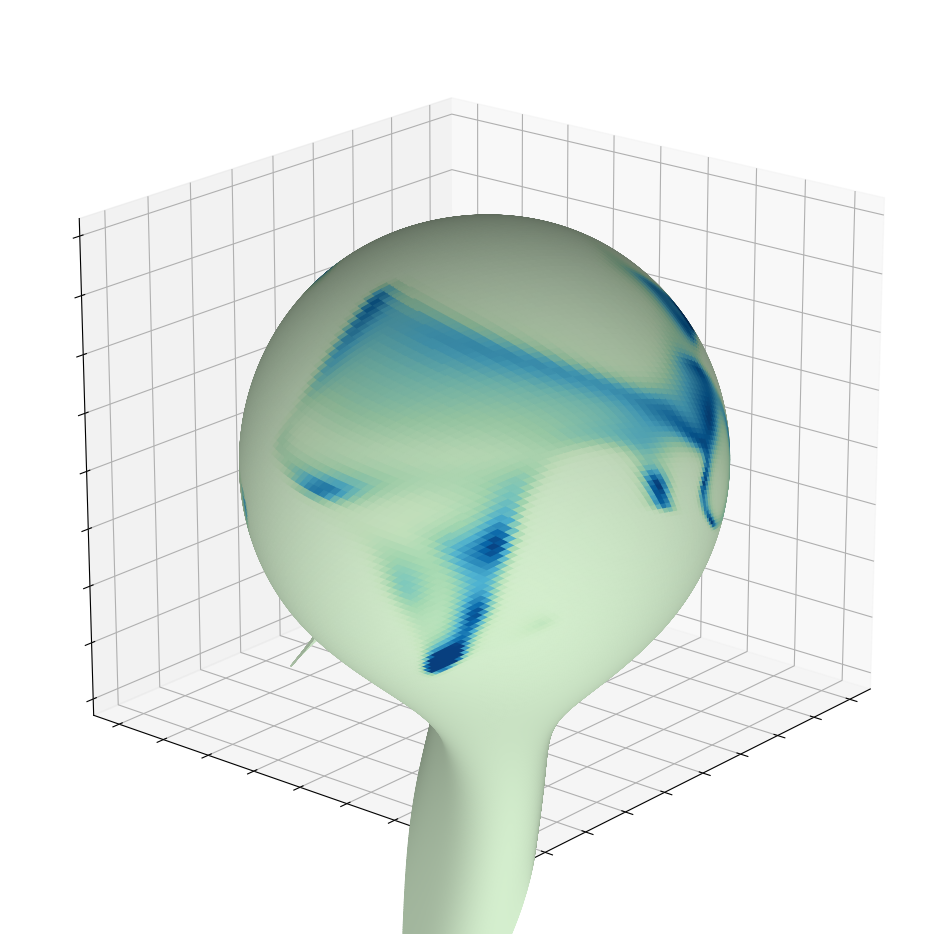

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")
plot_surface(ambient_grid, facecolors=densities, cmap=cmap, ax=ax, equal_aspect=True,
             **plot_lims)

ax.view_init(elev=20, azim=40)

In [18]:
from visualization import plot_surface
import matplotlib.colors as mcolors

with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    x = torch.linspace(lower[0].tolist(), upper[0].tolist(), 100)
    y = torch.linspace(lower[1].tolist(), upper[1].tolist(), 100)

    latent_points = torch.stack(torch.meshgrid((x, y), indexing="xy"), dim=-1).reshape(-1, 2)
    ae_ebm_points = decoder(latent_points)
    
    ae_ebm_densities = ae_ebm.prob(ae_ebm_points)
    
wasserstein_discretized_density_to_points(
    ae_ebm_points,
    ae_ebm_densities,
    gt_points,
    ebm_lims.T.numpy(),
    granularity=30,
)

0.0623498440622724